In [1]:
import sys
import os
import matplotlib.pyplot as plt

import numpy as np
import highdicom as hd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import scripts.dicom as dicom

In [2]:
%load_ext autoreload
%autoreload 2

# Objective 2: Segmentation 

In [ ]:
# Load DICOM files
path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "1685", "10_AP_Ax2.50mm"))

print(f"Loading DICOM files from {path}")
slices = dicom.load_dicom(path)

# Create a 3D array from the loaded slices
img_dcm = dicom.create_3d_array_from_dicom(slices)
print(f"3D image shape: {img_dcm.shape}")

# Obtain the pixel spacing, we will use the index 0, as all slices have the same spacing
pixel_spacing = slices[0].get("PixelSpacing")
print(f"Pixel spacing: {pixel_spacing}")

slice_spacing = slices[0].get("SpacingBetweenSlices")
print(f"Slice spacing: {slice_spacing}")

Loading DICOM files from /Users/josep/Documents/master/11763-Medical-Image-Processing-Final-Project/data/1685/10_AP_Ax2.50mm
3D image shape: (86, 512, 512)
Pixel spacing: [0.767578, 0.767578]
Slice spacing: 2.5


In [ ]:
# Load the tumor and liver segmentation masks
tumor_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "1685", "10_AP_Ax2.50mm_ManualROI_Tumor.dcm"))
liver_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "1685", "10_AP_Ax2.50mm_ManualROI_Liver.dcm"))

seg = hd.seg.segread(tumor_path)
liver_seg = hd.seg.segread(liver_path)

mask = seg.pixel_array

# Do the same that we did in the Objective 1 to load the full mask

# 1. Obtain the Z positions of each slice of the original volume (CT)
ct_z_positions = [float(slice.ImagePositionPatient[2]) for slice in slices]

# 2. Obtain the Z positions of each slice of the tumor
tumor_z_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg.PerFrameFunctionalGroupsSequence
]

# 3. Mapping the tumor slice indices to the original volume
tumor_slice_indices = [ct_z_positions.index(z) for z in tumor_z_positions]

# 4. Creathe the empty mask
full_mask = np.zeros_like(img_dcm, dtype=np.uint8)

# 5. Assign each slice of the tumor to its position
for i, idx in enumerate(tumor_slice_indices):
    full_mask[idx] = mask[i]

print(f"Full mask shape: {full_mask.shape}")

Full mask shape: (86, 512, 512)


In [5]:
# Do the same for the liver
liver_z_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in liver_seg.PerFrameFunctionalGroupsSequence
]

liver_slice_indices = [ct_z_positions.index(z) for z in liver_z_positions]

full_mask_liver = np.zeros_like(img_dcm, dtype=np.uint8)
for i, idx in enumerate(liver_slice_indices):
    full_mask_liver[idx] = liver_seg.pixel_array[i]

## Bounding boxes and centroid

In [6]:
import numpy as np
from scipy.ndimage import label, center_of_mass, find_objects

# Detect tumors in the full mask
labeled_mask, num_features = label(full_mask)
print(f"Number of connected components (tumors): {num_features}")
print(f"Labelled mask shape: {labeled_mask.shape}")

# Obtain the different bounding boxes of the tumors
bounding_boxes = find_objects(labeled_mask)

# Obtain the centroids of the tumors
centroids = center_of_mass(full_mask, labeled_mask, range(1, num_features + 1))

# Show the results
for i, (bbox, centroid) in enumerate(zip(bounding_boxes, centroids), start=1):
    z_slice, y_slice, x_slice = bbox
    print(f"Tumor {i}:")
    print(f"  Bounding box: Z={z_slice}, Y={y_slice}, X={x_slice}")
    print(f"  Centroid: Z={centroid[0]:.2f}, Y={centroid[1]:.2f}, X={centroid[2]:.2f}")

bbox_coords = []
for bbox in bounding_boxes:
    z, y, x = bbox
    bbox_coords.append((
        (z.start, y.start, x.start),
        (z.stop, y.stop, x.stop)
    ))

# Print the bounding box coordinates
for i, (start, stop) in enumerate(bbox_coords, start=1):
    print(f"Tumor {i} bounding box coordinates:")
    print(f"  Start: {start}")
    print(f"  Stop: {stop}")

Number of connected components (tumors): 5
Labelled mask shape: (86, 512, 512)
Tumor 1:
  Bounding box: Z=slice(26, 31, None), Y=slice(155, 173, None), X=slice(262, 277, None)
  Centroid: Z=28.21, Y=163.07, X=269.10
Tumor 2:
  Bounding box: Z=slice(26, 32, None), Y=slice(254, 270, None), X=slice(84, 99, None)
  Centroid: Z=28.71, Y=261.71, X=90.43
Tumor 3:
  Bounding box: Z=slice(45, 53, None), Y=slice(136, 169, None), X=slice(271, 300, None)
  Centroid: Z=48.25, Y=152.42, X=283.37
Tumor 4:
  Bounding box: Z=slice(55, 58, None), Y=slice(255, 271, None), X=slice(87, 104, None)
  Centroid: Z=56.09, Y=262.73, X=94.45
Tumor 5:
  Bounding box: Z=slice(58, 65, None), Y=slice(180, 208, None), X=slice(117, 143, None)
  Centroid: Z=61.29, Y=191.86, X=129.00
Tumor 1 bounding box coordinates:
  Start: (26, 155, 262)
  Stop: (31, 173, 277)
Tumor 2 bounding box coordinates:
  Start: (26, 254, 84)
  Stop: (32, 270, 99)
Tumor 3 bounding box coordinates:
  Start: (45, 136, 271)
  Stop: (53, 169, 300)


## Segmentation

In [ ]:
# Predict the tumor volume using Otsu's thresholding method
from skimage.filters import threshold_otsu

segmented_masks = []

# Iterate over each bounding box and apply Otsu's thresholding
for i, bbox in enumerate(bounding_boxes):
    z, y, x = bbox

    # Crop the subvolume from the CT image
    img_crop = img_dcm[z, y, x]

    # Flatten the subvolume to compute a global threshold
    flat = img_crop.flatten()
    flat = flat[flat > 0]  # remove background values

    if len(flat) == 0:
        segmented_masks.append(None)
        continue

    # Compute Otsu's threshold
    threshold = threshold_otsu(flat)

    # Create a binary mask using the threshold
    mask_seg = img_crop > threshold

    # Store the segmented mask
    segmented_masks.append(mask_seg)

# Initialize a blank mask with the same shape as the CT image
predicted_mask = np.zeros_like(img_dcm, dtype=bool)

# Insert each local segmentation into the full predicted mask
for bbox, local_mask in zip(bounding_boxes, segmented_masks):
    if local_mask is None:
        continue
    z, y, x = bbox
    predicted_mask[z, y, x] = local_mask

print(f"Predicted mask shape: {predicted_mask.shape}")

Predicted mask shape: (86, 512, 512)


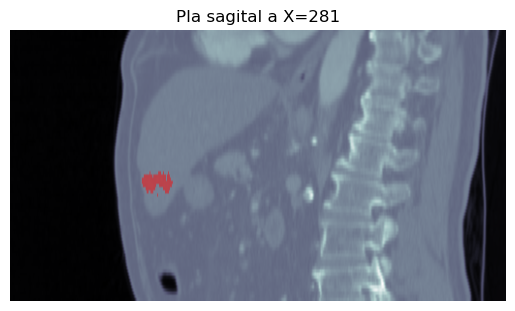

In [ ]:
# Plot the prediccted mask where the biggest tumor is located
sagital_sum = predicted_mask.sum(axis=(0,1))  # Shape: (X,)
max_index = np.argmax(sagital_sum)

# Get the corresponding plane and mask
plane = img_dcm[:, :, max_index]
mask_plane = predicted_mask[:, :, max_index]

# Normalize the plane and mask for visualization
plane_norm = (plane - np.min(plane)) / (np.max(plane) - np.min(plane))
plane_rgb = plt.cm.bone(plane_norm)[..., :3]

# Create a colored mask for overlay
mask_bool = mask_plane > 0
mask_norm = mask_bool.astype(float) / np.max(mask_plane)
mask_colored = plt.cm.jet(mask_norm)[..., :3]

# Overlay the mask on the plane
red = np.array([1.0, 0.0, 0.0])
alpha = 0.5

overlay = plane_rgb.copy()
overlay[mask_bool] = (1 - alpha) * plane_rgb[mask_bool] + alpha * red

plt.imshow(overlay, cmap="bone", aspect=slice_spacing / pixel_spacing[0])
plt.title(f"Pla sagital a X={max_index}")
plt.axis("off")
plt.show()

In [ ]:
# Now, we are going to create the rotated projections of the CT volume with the tumor prediction and liver mask
import scipy

def rotate_on_axial_plane(volume: np.ndarray, angle: float, order=3, cval=0.0) -> np.ndarray:
    """Rotate volume on the axial plane (Z-axis)."""
    return scipy.ndimage.rotate(volume, angle, axes=(1, 2), reshape=False, mode='constant', order=order, cval=cval)

# Define colors
red = np.array([1.0, 0.0, 0.0])
yellow = np.array([1.0, 1.0, 0.0])

output_dir = '../outputs/projection_prediction/'
os.makedirs(output_dir, exist_ok=True)

# Parameters
n = 16  # number of projections
alpha_overlay = 0.5  # for tumor prediction
alpha_liver = 0.3    # for liver

# Use full volume intensity range
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)

n = 16

for idx, angle in enumerate(np.linspace(0, 360 * (n - 1) / n, num=n)):
    # Rotate the image and the mask
    rotated_img = rotate_on_axial_plane(img_dcm, angle, order=3, cval=img_min)
    rotated_mask = rotate_on_axial_plane(predicted_mask, angle, order=0, cval=0)
    rotated_mask_liver = rotate_on_axial_plane(full_mask_liver, angle, order=0, cval=0)

    # Create projections
    projection = rotated_img.max(axis=2)
    projection_mask = rotated_mask.max(axis=2)
    projection_mask_liver = rotated_mask_liver.max(axis=2)

    # Normalize the projection for visualization
    projection_norm = (projection - img_min) / (img_max - img_min)
    projection_rgb = np.clip(plt.cm.bone(projection_norm)[..., :3], 0, 1)
    
    # Create overlay image
    overlay = projection_rgb.copy()

    # Liver mask overlay (yellow)
    if np.max(projection_mask_liver) > 0:
        mask_bool_liver = projection_mask_liver > 0
        overlay[mask_bool_liver] = (
            (1 - alpha_liver) * projection_rgb[mask_bool_liver] + alpha_liver * yellow
        )

    # Tumor prediction overlay (red)
    if np.max(projection_mask) > 0:
        mask_bool = projection_mask > 0
        overlay[mask_bool] = (
            (1 - alpha_overlay) * projection_rgb[mask_bool] + alpha_overlay * red
        )


    # Save the resulting image
    fig, ax = plt.subplots()
    ax.imshow(overlay, aspect=slice_spacing / pixel_spacing[0])
    ax.axis("off")
    fig.savefig(os.path.join(output_dir, f'Projection_{idx}.png'), bbox_inches='tight', pad_inches=0)
    plt.close(fig)


In [ ]:
# Create a GIF animation from the saved images (rotated projections)
from PIL import Image

# Route
image_folder = '../outputs/projection_prediction/'
output_gif = '../outputs/projection_prediction/Animation.gif'

# Sort the image files by their index
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')],
                     key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Load images
images = [Image.open(os.path.join(image_folder, f)) for f in image_files]

# Save as GIF
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=250,
    loop=0
)

## Create a gif with all the frames (coronal)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops
from PIL import Image
import io

# Colors
red = np.array([1.0, 0.0, 0.0])     # Prediction
yellow = np.array([1.0, 1.0, 0.0])  # Ground truth
green = np.array([0.0, 1.0, 0.0])   # Intersection

# Parameters
alpha_overlay = 0.5
output_dir = '../outputs/coronal_gif/'
os.makedirs(output_dir, exist_ok=True)

# Normalitzation
img_min = np.min(img_dcm)
img_max = np.max(img_dcm)

# Create a GIF animation of the coronal slices with tumor prediction and ground truth overlay
frames = []
for y in range(100, img_dcm.shape[1]):  # Iterate over the Y-axis (coronal slices)
    img_slice = img_dcm[:, y, :]
    pred_slice = predicted_mask[:, y, :]
    gt_slice = full_mask[:, y, :]

    # Normalize the image slice for visualization
    img_norm = (img_slice - img_min) / (img_max - img_min)
    img_rgb = plt.cm.bone(img_norm)[..., :3]

    overlay = img_rgb.copy()
    pred_mask = pred_slice > 0
    gt_mask = gt_slice > 0

    # Create the masks for the overlays
    only_pred = pred_mask & ~gt_mask
    only_gt = gt_mask & ~pred_mask
    both = pred_mask & gt_mask

    # Aplly the colors to the overlay
    overlay[only_pred] = (1 - alpha_overlay) * overlay[only_pred] + alpha_overlay * red
    overlay[only_gt] = (1 - alpha_overlay) * overlay[only_gt] + alpha_overlay * yellow
    overlay[both] = (1 - alpha_overlay) * overlay[both] + alpha_overlay * green

    # Plot the overlay
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(overlay, aspect=slice_spacing / pixel_spacing[0])
    ax.axis("off")
    ax.set_title(f"Coronal slice Y={y}", fontsize=12)

    # Plot the bounding boxes and centroids for ground truth
    for region in regionprops(label(gt_mask)):
        minr, minc, maxr, maxc = region.bbox
        ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr,
                               edgecolor='yellow', facecolor='none', linewidth=1))
        cy, cx = region.centroid
        ax.plot(cx, cy, 'yo', markersize=3)
        

    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')
    frames.append(img)
    buf.close()
    plt.close(fig)

# Save the frames as a GIF
gif_path = os.path.join(output_dir, "coronal_tumor_overlay.gif")
frames[0].save(gif_path, format='GIF', save_all=True, append_images=frames[1:], duration=150, loop=0)

print(f"GIF creat a: {gif_path}")

GIF creat a: ../outputs/coronal_gif/coronal_tumor_overlay.gif


# Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# Compute segmentation metrics in all the image slices

def compute_segmentation_metrics(pred_mask: np.ndarray, gt_mask: np.ndarray):
    # Flatten the masks
    y_pred = pred_mask.flatten()
    y_true = gt_mask.flatten()

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

# Compute metrics for the predicted mask
metrics_pred = compute_segmentation_metrics(predicted_mask, full_mask)

print("Metrics for the predicted mask:")
for metric, value in metrics_pred.items():
    print(f"{metric}: {value}")

Metrics for the predicted mask:
TP: 4858
FP: 743
TN: 22536022
FN: 2761
Accuracy: 0.9998445732648983
Precision: 0.867345116943403
Recall (Sensitivity): 0.6376164851030319
Specificity: 0.9999670316480649
F1-score: 0.734947049924357


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# Compute the metrics only in the bounding boxes of the tumors

def compute_metrics_in_bbox(pred_mask, gt_mask, bbox):
    z, y, x = bbox

    pred_crop = pred_mask[z, y, x]
    gt_crop = gt_mask[z, y, x]

    if np.sum(gt_crop) == 0 and np.sum(pred_crop) == 0:
        return None  # Skip completely empty cases

    y_true = gt_crop.flatten()
    y_pred = pred_crop.flatten()

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

In [ ]:
import pandas as pd

metrics_all = []
gt_mask = full_mask

# Iterate over each bounding box and compute the metrics
for bbox in bounding_boxes:
    metrics = compute_metrics_in_bbox(predicted_mask, gt_mask, bbox)
    if metrics is not None:
        metrics_all.append(metrics)

# Create a DataFrame from the metrics and compute the mean
df_metrics = pd.DataFrame(metrics_all)
mean_metrics = df_metrics.mean()

print("Average metrics inside bounding boxes:")
print(mean_metrics)

Average metrics inside bounding boxes:
TP                       971.600000
FP                       148.600000
TN                      1599.200000
FN                       552.200000
Accuracy                   0.758561
Precision                  0.850272
Recall (Sensitivity)       0.615647
Specificity                0.894665
F1-score                   0.711551
dtype: float64


In [ ]:
# Compute the metrics for each bounding box
metrics_all = []
gt_mask = full_mask.astype(np.uint8)

for i, bbox in enumerate(bounding_boxes):
    metrics = compute_metrics_in_bbox(predicted_mask, gt_mask, bbox)
    if metrics is not None:
        metrics["bbox_index"] = i  # Add bounding box index for identification
        metrics_all.append(metrics)

# Transform the metrics into a DataFrame
df_metrics = pd.DataFrame(metrics_all)

# Show the metrics for each bounding box
print("Metrics per bounding box:")
print(df_metrics)

# Compute the mean metrics across all bounding boxes
mean_metrics = df_metrics.mean(numeric_only=True)
print("\nAverage metrics across all bounding boxes:")
print(mean_metrics)

Metrics per bounding box:
     TP   FP    TN    FN  Accuracy  Precision  Recall (Sensitivity)  \
0   486  103   514   247  0.740741   0.825127              0.663029   
1   436   71   655   278  0.757639   0.859961              0.610644   
2  2080  321  3815  1440  0.769984   0.866306              0.590909   
3   194   46   359   217  0.677696   0.808333              0.472019   
4  1662  202  2653   579  0.846743   0.891631              0.741633   

   Specificity  F1-score  bbox_index  
0     0.833063  0.735250           0  
1     0.902204  0.714169           1  
2     0.922389  0.702584           2  
3     0.886420  0.596006           3  
4     0.929247  0.809744           4  

Average metrics across all bounding boxes:
TP                       971.600000
FP                       148.600000
TN                      1599.200000
FN                       552.200000
Accuracy                   0.758561
Precision                  0.850272
Recall (Sensitivity)       0.615647
Specificity      